# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import shutil
import zipfile
import urllib.request
import pickle

import numpy as np
import pandas as pd
from IPython.display import display
import scipy.linalg

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
colors = [x['color'] for x in plt.style.library['seaborn']['axes.prop_cycle']]
plt.rcParams.update({'font.size': 12})

In [2]:
if not os.path.isdir('data'): os.mkdir('data')
if not os.path.isdir('results'): os.mkdir('results')

**Setings:**

In [3]:
# a. CPS settings
DO_CPS = True # download CPS data if not already downloaded
CPS_END_YEAR = 2019 # last year to download
CPS_END_MONTH = 12 # last month to download

# the data starts in 1967-06

# b. stata
DO_RUN_STATA = True # re-run stata
STATA_EXE = '"C:\Program Files (x86)\Stata15\StataMP-64.exe"'

# Auxiliary functions

## Download

In [4]:
def download_and_unzip(url,name):
    
    zipfilename = f'{os.getcwd()}/{name}.zip'
    folder = f'{os.getcwd()}/{name}/'
    
    if os.path.isdir(folder): 
        print(f'data already downloaded and extracted to {name}')
        return
    
    # b. download
    urllib.request.urlretrieve(url,zipfilename)
    
    # c. unzip
    with zipfile.ZipFile(zipfilename) as file:
        file.extractall(folder)
        
    print(f'downloaded and extracted to {name}/')
        

## Stata

In [5]:
def run_stata(filename):
    
    # a. run
    os.system(f'{STATA_EXE} /UseRegistryStartin /e {os.getcwd()}/{filename}.do')
    
    # b. check if terminated succesfully
    with open(f'{filename}.log') as logfile:
        
        lastline = list(logfile)[-1]
        
        if lastline == 'end of do-file\n':
            print(f'{filename} terminated succesfully')
        else:
            raise Exception(f'{filename} did not terminate succesfully\n {lastline}')
    
    # c. clean up
    os.remove(f'{filename}.log')


## Download

## Shimer code

Original download and unzip.

In [6]:
url = 'https://sites.google.com/site/robertshimer/grossflows.zip?attredirects=0'
download_and_unzip(url,'grossflows')

data already downloaded and extracted to grossflows


## CPS

In [7]:
if DO_CPS:
    
    baseurl = 'https://data.nber.org/cps-basic2/raw/'
    
    for year in range(1976,CPS_END_YEAR+1):
        for month in range(1,CPS_END_MONTH+1):
            
            filename = f'cpsb{year}{str(month).zfill(2)}.raw'
            url = baseurl + filename
            data_filename = 'data/' + filename
            
            if os.path.isfile(data_filename):
                print(f'{filename} already downloaded to data/')
            else:
                urllib.request.urlretrieve(url,data_filename)
                print(f'{data_filename} downloaded and saved in data/')


cpsb197601.raw already downloaded to data/
cpsb197602.raw already downloaded to data/
cpsb197603.raw already downloaded to data/
cpsb197604.raw already downloaded to data/
cpsb197605.raw already downloaded to data/
cpsb197606.raw already downloaded to data/
cpsb197607.raw already downloaded to data/
cpsb197608.raw already downloaded to data/
cpsb197609.raw already downloaded to data/
cpsb197610.raw already downloaded to data/
cpsb197611.raw already downloaded to data/
cpsb197612.raw already downloaded to data/
cpsb197701.raw already downloaded to data/
cpsb197702.raw already downloaded to data/
cpsb197703.raw already downloaded to data/
cpsb197704.raw already downloaded to data/
cpsb197705.raw already downloaded to data/
cpsb197706.raw already downloaded to data/
cpsb197707.raw already downloaded to data/
cpsb197708.raw already downloaded to data/
cpsb197709.raw already downloaded to data/
cpsb197710.raw already downloaded to data/
cpsb197711.raw already downloaded to data/
cpsb197712.

# Run STATA

**Update .do files with new year and month**

In [8]:
# a. match_extract
lines_ = []
with open('grossflows/match_extract.do','r') as f:
    lines = f.readlines()
    for line in lines:
        if line == "while `x' <=200501 {\n":
            line = f"while `x' <={CPS_END_YEAR}{str(CPS_END_MONTH).zfill(2)} {{\n"
            print('change made in match_extract')            
        lines_.append(line)

with open('grossflows/match_extract_.do','w') as f:
    f.writelines(lines_)
    
# c. match_merge
lines_ = []
with open('grossflows/match_merge.do','r') as f:
    lines = f.readlines()
    for line in lines:
        if line == "while `first' <=200412  {\n":
            CPS_END_MONTH_ = CPS_END_MONTH-1 if CPS_END_MONTH > 1 else 12
            line = f"while `first' <={CPS_END_YEAR}{str(CPS_END_MONTH_).zfill(2)} {{\n"
            print('change made in match_merge')
        lines_.append(line)

with open('grossflows/match_merge_.do','w') as f:
    f.writelines(lines_)
    
# c. match_flows
lines_ = []
with open('grossflows/match_flows.do','r') as f:
    lines = f.readlines()
    for line in lines:
        if line == "while `x' <= 200501 {\n":
            line = f"while `x' <={CPS_END_YEAR}{str(CPS_END_MONTH).zfill(2)} {{\n"
            print('change made in match_flows')
        lines_.append(line)

with open('grossflows/match_flows_.do','w') as f:
    f.writelines(lines_)

change made in match_extract
change made in match_merge
change made in match_flows


**Write run.do**

In [9]:
with open('run.do','w') as dofile:
    
    # simular to match.do
    
    dofile.write(f'cd {os.getcwd()}/data\n')
    dofile.write('version 7.0\n')
    dofile.write('set more 1\n')
    dofile.write('clear\n')
    dofile.write('set mem 50m\n')
    dofile.write('log using run, replace\n')
    dofile.write(f'do {os.getcwd()}/grossflows/match_extract_.do\n') # use updated file
    dofile.write(f'do {os.getcwd()}/grossflows/match_merge_.do\n') # use updated file
    dofile.write(f'do {os.getcwd()}/grossflows/match_flows_.do\n') # use updated file
    dofile.write(f'do {os.getcwd()}/grossflows/match_sa.do\n')
    dofile.write(f'log close\n')
    

**Run run.do**

In [10]:
if DO_RUN_STATA:
    
    # a. remove .dta files
    for file in os.listdir('data/'):
        if file.endswith('.dta'):
            filename = os.path.join("data", file)
            os.remove(filename)
    
    # b. copy in old flows data
    shutil.copy('grossflows/flows_67.dta','data/flows_67.dta')
    
    # c. run
    run_stata('run')
    

run terminated succesfully


# Compute transition rates

## Load and clean data

In [11]:
data = pd.read_stata('data/seasadj.dta') # output from STATA

**Note:** Double entry for 197601. Remove it.

In [12]:
display(data.iloc[102:106,:])
data = data.drop(103)

,date,SA_EE,SA_EU,SA_EI,SA_UE,SA_UU,SA_UI,SA_IE,SA_IU,SA_II
102,197512.0,0.949219,0.016510,0.034386,0.229878,0.552209,0.207675,0.042875,0.029179,0.927773
103,197601.0,0.951191,0.015127,0.032635,0.212872,0.571478,0.200499,0.045103,0.028319,0.925897
104,197601.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,197602.0,0.950359,0.014793,0.034762,0.227243,0.572181,0.190059,0.039683,0.026468,0.932639


## Discrete transition probabilities

**Length of time series**

In [13]:
T = data.shape[0]
dates = np.arange('1967-06', np.datetime64('1967-06')+T, dtype='datetime64[M]')

**Discrete transition probabilities**

In [14]:
P = np.nan*np.ones((T,3,3))
P_data = {}
for i,name_i in enumerate(['E','U','I']):
    for j,name_j in enumerate(['E','U','I']):
        name = f'{name_i}{name_j}'
        values = data.loc[:,f'SA_{name}']
        P[:,i,j] = values

**Fill missing values with values for previous month and rescale each row to 1**

In [15]:
for t in range(T):
    if np.any(np.isnan(P[t])):
        print(f'missing values for t = {t}')
        P[t,:,:] = P[t-1,:,:]
    else:
        for i in range(3):
            P[t,i,:] /= np.sum(P[t,i,:])

missing values for t = 103
missing values for t = 127
missing values for t = 217
missing values for t = 220
missing values for t = 319
missing values for t = 336
missing values for t = 337
missing values for t = 338
missing values for t = 339


**Save**

In [16]:
for i,name_i in enumerate(['E','U','I']):
    for j,name_j in enumerate(['E','U','I']):    
        name = f'{name_i}{name_j}'
        P_data[name] = pd.Series(data=P[:,i,j],name=name,index=dates)

In [17]:
with open('P.p','wb') as f:
    pickle.dump(P_data,f)

## Continuous time transition rates

**Transition rate matrix**

In [18]:
Q = np.nan*np.ones((T,3,3))
for t in range(0,T):        
    if not np.any(np.isnan(P[t])):
          
        # a. eigenvalue decomposition
        mu,p = scipy.linalg.eig(P[t])
        
        # b. matrix
        mu_mat = np.zeros((3,3))
        np.fill_diagonal(mu_mat,np.log(np.real(mu)))
        
        # c. Q
        Q[t] = p@mu_mat@np.linalg.inv(p)

**Save**

In [19]:
Q_data = {}
for i,name_i in enumerate(['E','U','I']):
    for j,name_j in enumerate(['E','U','I']):
        name = f'{name_i}{name_j}'
        values = Q[:,i,j]
        Q_data[name] = pd.Series(name=name,data=values,index=dates)

In [20]:
with open('Q.p','wb') as f:
    pickle.dump(Q_data,f)

# Overview

### EE ###


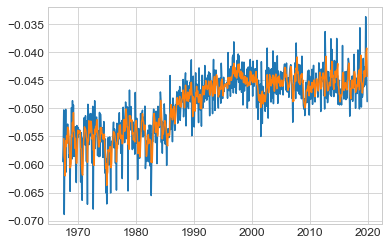

### EU ###


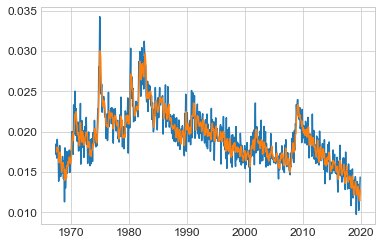

### EI ###


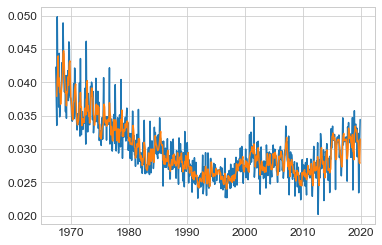

### UE ###


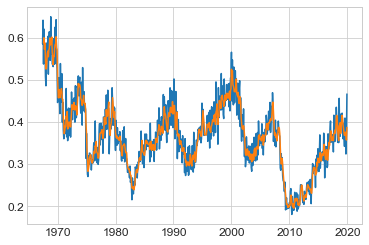

### UU ###


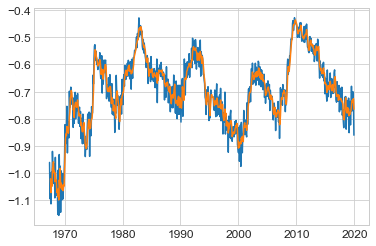

### UI ###


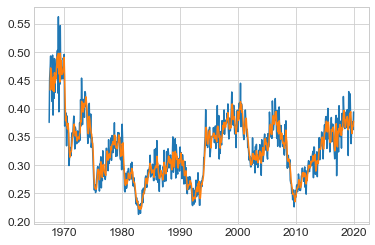

### IE ###


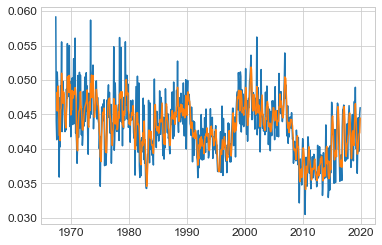

### IU ###


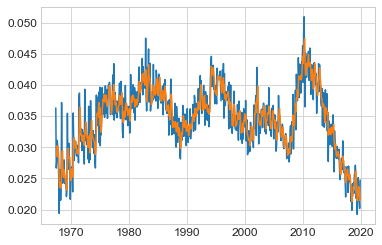

### II ###


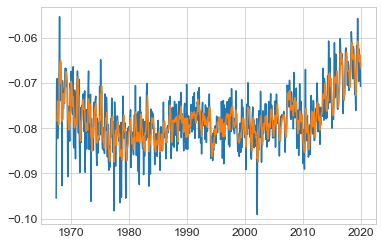

In [21]:
for k,v in Q_data.items():
    
    print(f'### {k} ###')
    
    fig = plt.figure(figsize=(6,6/1.5))
    ax = fig.add_subplot(1,1,1)    
    ax.plot(v)
    ax.plot(v.rolling(3).mean())
    plt.show()
    
    fig.tight_layout()
    fig.savefig(f'results/data_{k}.pdf')
    

# Comparison with Shimer (2015) (quarterly data)

**Download**

In [22]:
def download_shinmer(url,name):
    
    if not os.path.isdir('data/shimer'): os.mkdir('data/shimer')
        
    # a. download (if not already downloaded)
    filename = f'data/shimer/{name}.txt'
    if not os.path.isfile(filename):        
        urllib.request.urlretrieve(url,filename)    
    
    # b. read
    df = pd.read_csv(filename,sep='   ',header=None,names=['date_float',name],engine='python')
    
    # c. date
    df['year'] = np.floor(df.date_float).astype('int').astype('str')
    df['quarter'] = (1+(df.date_float-np.floor(df.date_float))*4).astype('int').astype('str')
    df['date'] = pd.to_datetime(df['year'] + '-Q' + df['quarter'])
    
    del df['date_float']
    del df['year']
    del df['quarter']
    
    # d. return
    df[name] = pd.to_numeric(df[name])
    df = df.set_index('date')
    
    return 100*df[name]


In [23]:
shimer = {}
varnames = ['EU','EI','UE','UI','IE','IU']
for varname in varnames:
    url = f'https://sites.google.com/site/robertshimer/{varname.lower()}.dat?attredirects=0'
    shimer[varname] = download_shinmer(url,varname)

**Comparison**

### EU ###
corr = 0.9739


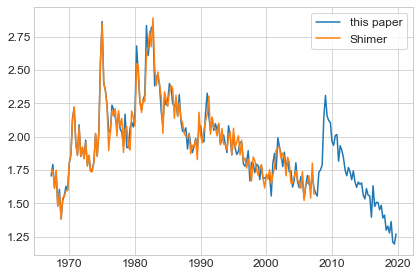

### EI ###
corr = 0.9740


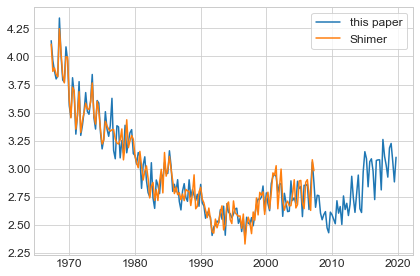

### UE ###
corr = 0.9807


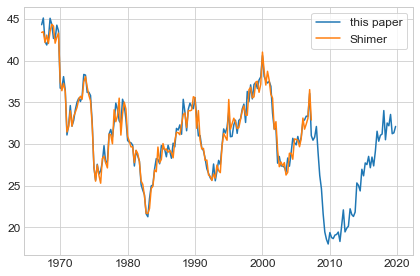

### UI ###
corr = 0.9846


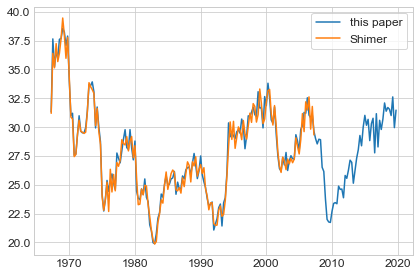

### IE ###
corr = 0.8863


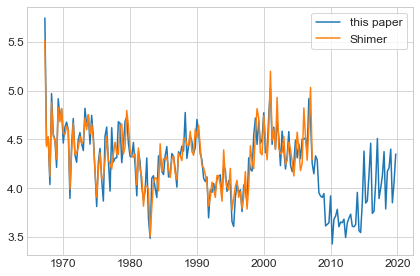

### IU ###
corr = 0.9600


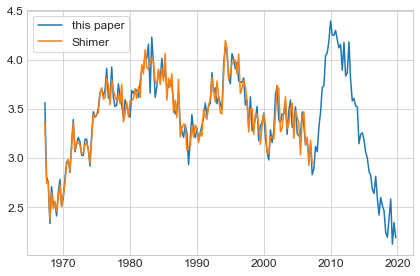

In [24]:
for varname in varnames:
    
    print(f'### {varname} ###')
    
    fig = plt.figure(figsize=(6,6/1.5))
    ax = fig.add_subplot(1,1,1)    
    
    # a. ours
    Q_qrt = Q_data[varname].resample('Q',label='left').mean()
    Q_qrt.index += pd.tseries.frequencies.to_offset('1D')
    y_ours = 100*(1-np.exp(-Q_qrt))
    ax.plot(y_ours,label='this paper')
    
    # b. Shimer
    y_shimer = shimer[varname]
    ax.plot(y_shimer,label='Shimer')
    
    ax.legend(frameon=True)
    
    corr = np.corrcoef(y_ours[y_shimer.index],y_shimer)[0,1]
    print(f'corr = {corr:.4f}')
    
    fig.tight_layout()
    fig.savefig(f'results/shimer_{varname}.pdf')
    plt.show()
    